In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/AudioProcessing/Emotion_Recognition'
%ls

/content/drive/My Drive/AudioProcessing/Emotion_Recognition
 CREMA/     kaggle.json            RAVDESS_copied/                     try/
 EMODB/     model.png              SAVEE/
 EMO_DB/   'Papers & Materials'@   speech-emotion-recognition-en.zip
 IEMOCAP/   RAVDESS/               TESS/


In [ ]:
from keras.layers import *
from keras.models import *
from keras.callbacks import ModelCheckpoint, Callback
from sklearn.preprocessing import  StandardScaler
import sklearn
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
import tensorflow as tf
import csv
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
from sklearn import feature_selection
import matplotlib.pyplot as plt

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 5
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "SAVEE//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "SAVEE//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "SAVEE//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (207, 80000, 1) (207, 4)
Test Data (45, 80000, 1) (45, 4)
Val Data (44, 80000, 1) (44, 4)


In [ ]:
csvpath = 'SAVEE/hand_engineered_features_SAVEE_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'SAVEE/hand_engineered_features_SAVEE_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'SAVEE/hand_engineered_features_SAVEE_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(207, 26) (207, 1)
(45, 26) (45, 1)
(44, 26) (44, 1)


In [ ]:
def findmaxsize(rslt_df):

    sizes = []
    for index, row in rslt_df.iterrows(): 
      filename = row['path']

      y, sr = librosa.core.load(filename)
          
      # Computing the mel spectrograms
      spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
      spect = librosa.power_to_db(spect, ref=np.max)
      
      # Adding the size to the list
      sizes.append(spect.shape)
    print(f'The sizes of all the mel spectrograms in our data set are equal: {len(set(sizes)) == 1}')

    # Checking the max size
    print(f'The maximum size is: {max(sizes)}')


    return max(sizes)


X = pd.read_csv('SAVEE/SAVEE_details.csv',usecols=['labels','path'])
options = ['angry', 'happy','neutral','sad'] 

time = 4
rslt_df = X[X['labels'].isin(options)]




max_x,max_y = findmaxsize(rslt_df)

The sizes of all the mel spectrograms in our data set are equal: False
The maximum size is: (128, 154)


In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def extract_mel_spectrogram(df,max_x,max_y):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path']

      y, sr = librosa.core.load(filename)
      spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
      spect = librosa.power_to_db(spect, ref=np.max)

            # Adjusting the size to be 128 x 660
      if spect.shape[1] != max_y:
                #print('Sizes arent same')
              spect.resize(max_x,max_y, refcheck=False)

      mel_specs.append(spect)
      labels.append(label_to_onehot(row['labels']))
  mel_specs = np.array(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels

train_path = "SAVEE//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv,max_x,max_y)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
X_train_spec = np.expand_dims(X_train_spec,axis=3)
print(X_train_spec.shape,Y_train_spec.shape)


test_path = "SAVEE//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv,max_x,max_y)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
X_test_spec = np.expand_dims(X_test_spec,axis=3)
print(X_test_spec.shape,Y_test_spec.shape)

val_path = "SAVEE//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv,max_x,max_y)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
X_val_spec = np.expand_dims(X_val_spec,axis=3)
print(X_val_spec.shape,Y_val_spec.shape)

(207, 128, 154, 1) (207, 4)
(45, 128, 154, 1) (45, 4)
(44, 128, 154, 1) (44, 4)


# Dataset Download

In [ ]:
! pip install -q kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

In [ ]:
!kaggle datasets download -d barelydedicated/savee-database

100% 215M/215M [00:08<00:00, 13.5MB/s]



In [ ]:
import zipfile
path_to_zip_file = "SAVEE//savee-database.zip"
directory_to_extract_to = "SAVEE"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

# Dataset Pre Processing

In [ ]:
def decompose_savee():

        PATH = 'SAVEE/AudioData/'
        emotion = []
        path = []
        for dirname, _, filenames in os.walk(PATH):
          for name in filenames[1:]:
                    #print(name,len(name),name[6:8], dirname)
                    #e = name[6:8]
                
                    if name[0] == 'a':  
                        emotion.append('angry')
                    elif name[0] == 'd':   
                        emotion.append('disgust')
                    elif name[0] == 'f':  
                        emotion.append('fear')
                    elif name[0] == 'h':  
                        emotion.append('happy')
                    elif name[0] == 'n':  
                        emotion.append('neutral')
                    elif name[0:2] == 'sa':   
                        emotion.append('sad')
                    elif name[0:2] == 'su':   
                        emotion.append('surprise')
                    
                    else:
                        print(name)
                        #emotion.append('m_neutral')
                

                    path.append(os.path.join(dirname,name))

        print(len(path),len(emotion))
        savee_df = pd.DataFrame(emotion, columns=['labels'])
        #emodb_df['source'] = 'EMODB'
        savee_df = pd.concat([savee_df, pd.DataFrame(path, columns=['path'])], axis=1)
        
        return savee_df

In [ ]:
df = decompose_savee()
print(df.shape)
df.to_csv('SAVEE/SAVEE_details.csv',index=False,index_label=False)

476 476
(476, 2)


In [ ]:
df.head()

,labels,path
0,angry,SAVEE/AudioData/DC/a02.wav
1,angry,SAVEE/AudioData/DC/a03.wav
2,angry,SAVEE/AudioData/DC/a04.wav
3,angry,SAVEE/AudioData/DC/a05.wav
4,angry,SAVEE/AudioData/DC/a06.wav


In [ ]:
#angry, happy, neutral, sad
X = pd.read_csv('SAVEE/SAVEE_details.csv',usecols=['labels','path'])
options = ['angry', 'happy','neutral','sad'] 
  
rslt_df = X[X['labels'].isin(options)] 
print(np.unique(rslt_df.labels))
print(rslt_df.shape)
rslt_df.head()

['angry' 'happy' 'neutral' 'sad']
(296, 2)


,labels,path
0,angry,SAVEE/AudioData/DC/a02.wav
1,angry,SAVEE/AudioData/DC/a03.wav
2,angry,SAVEE/AudioData/DC/a04.wav
3,angry,SAVEE/AudioData/DC/a05.wav
4,angry,SAVEE/AudioData/DC/a06.wav


In [ ]:
'''sizes = []
for index, row in rslt_df.iterrows(): 
    #print(row['labels'],row['path'])
    y, sr = librosa.load(row['path'], mono=True, duration=30)
    sizes.append(y.shape[0])
    
print('The max size is',max(sizes))
print('The average size is ', sum(sizes)/len(sizes))
print(sr)'''

The max size is 157409
The average size is  84720.57432432432
22050


In [ ]:
test_val= rslt_df.sample(frac = 0.3)
train = rslt_df.drop(test_val.index)

test= test_val.sample(frac = 0.5)
val = test_val.drop(test.index)
print(val['labels'].unique())
print(test['labels'].unique())
print(train['labels'].unique())

['angry' 'happy' 'neutral' 'sad']
['happy' 'sad' 'neutral' 'angry']
['angry' 'happy' 'neutral' 'sad']


In [ ]:
train.to_csv("SAVEE//train.csv")
test.to_csv("SAVEE//test.csv")
val.to_csv("SAVEE//val.csv")

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def extract_features(csvpath,path):
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    file = open(csvpath, 'w', newline='')
    with file:
      writer = csv.writer(file)
      writer.writerow(header)
    rslt_df = pd.read_csv(path,usecols=['labels','path'])
    for index, row in rslt_df.iterrows(): 
        filename = row['path']
        y, sr = librosa.load(row['path'], mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f' {filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
                    to_append += f' {np.mean(e)}'
        onehot_label = label_to_onehot(row['labels'])
        to_append += f' {np.argmax(onehot_label)}'
        file = open(csvpath, 'a', newline='')
        with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split())

train_csv = "SAVEE//train.csv"
test_csv = "SAVEE//test.csv"
val_csv = "SAVEE//val.csv"
csvpath = 'SAVEE//hand_engineered_features_SAVEE_train.csv'
extract_features(csvpath,train_csv)
csvpath = 'SAVEE//hand_engineered_features_SAVEE_test.csv'
extract_features(csvpath,test_csv)
csvpath = 'SAVEE//hand_engineered_features_SAVEE_val.csv'
extract_features(csvpath,val_csv)

# Wavenet Paper

In [ ]:
# hyper-parameters
n_filters = 32
filter_width = 2
dilation_rates = [2**i for i in range(4)] * 2 
sr = 16000
# define an input history series and pass it through a stack of dilated causal convolution blocks
history_seq = Input(shape=(int(sr*time), 1))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gate
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # combine filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))
out = AveragePooling1D(sr*time)(out)
out = Conv1D(8,1,activation='relu')(out)
out = Conv1D(4,1,activation='softmax')(out)
out = Reshape((4,1))(out)

Wavenet_paper = Model(history_seq, out)
Wavenet_paper.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 80000, 1)]   0                                            
__________________________________________________________________________________________________
conv1d_170 (Conv1D)             (None, 80000, 16)    32          input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_171 (Conv1D)             (None, 80000, 32)    1056        conv1d_170[0][0]                 
__________________________________________________________________________________________________
conv1d_172 (Conv1D)             (None, 80000, 32)    1056        conv1d_170[0][0]                 
____________________________________________________________________________________________

In [ ]:
Wavenet_paper.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('SAVEE//models//wavenet_paper_loss_1.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('SAVEE//models//wavenet_paper_acc_1.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = Wavenet_paper.fit(X_train,Y_train, batch_size=16,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
13/13 [==============================] - 13s 797ms/step - loss: 1.3828 - accuracy: 0.7500 - val_loss: 1.3709 - val_accuracy: 0.7500

Epoch 00001: val_loss improved from inf to 1.37090, saving model to SAVEE//models/wavenet_paper_loss_1.h5

Epoch 00001: val_accuracy improved from -inf to 0.75000, saving model to SAVEE//models/wavenet_paper_acc_1.h5
Epoch 2/30
13/13 [==============================] - 10s 753ms/step - loss: 1.3732 - accuracy: 0.7500 - val_loss: 1.3659 - val_accuracy: 0.7500

Epoch 00002: val_loss improved from 1.37090 to 1.36592, saving model to SAVEE//models/wavenet_paper_loss_1.h5

Epoch 00002: val_accuracy did not improve from 0.75000
Epoch 3/30
13/13 [==============================] - 10s 754ms/step - loss: 1.3584 - accuracy: 0.7500 - val_loss: 1.3634 - val_accuracy: 0.7500

Epoch 00003: val_loss improved from 1.36592 to 1.36335, saving model to SAVEE//models/wavenet_paper_loss_1.h5

Epoch 00003: val_accuracy did not improve from 0.75000
Epoch 4/30
13/13 [=

In [ ]:
Wavenet_paper.load_weights('SAVEE//models//wavenet_paper_loss_1.h5')
print(Wavenet_paper.evaluate(X_test,Y_test))
Wavenet_paper.load_weights('SAVEE//models//wavenet_paper_acc_1.h5')
Wavenet_paper.evaluate(X_test,Y_test)

2/2 [==============================] - 1s 221ms/step - loss: 0.7804 - accuracy: 0.7778
[0.7803704142570496, 0.7777777910232544]
2/2 [==============================] - 1s 220ms/step - loss: 0.7381 - accuracy: 0.8056


[0.7380579710006714, 0.8055555820465088]

In [ ]:
Wavenet_paper.load_weights('SAVEE//models//wavenet_paper_loss.h5')
print(Wavenet_paper.evaluate(X_test,Y_test))
Wavenet_paper.load_weights('SAVEE//models//wavenet_paper_acc.h5')
Wavenet_paper.evaluate(X_test,Y_test)

2/2 [==============================] - 1s 372ms/step - loss: 0.8630 - accuracy: 0.7944
[0.8629531860351562, 0.7944444417953491]
2/2 [==============================] - 1s 227ms/step - loss: 0.8804 - accuracy: 0.7944


[0.880372941493988, 0.7944444417953491]

F1 SCORE: 0.399536752804599
Kappa: 0.35298346513299783
Accuracy: 0.5555555555555556
Jaccard Score: 0.29638157894736844
Precision: 0.3728167967298402
Recall: 0.4361111111111111
              precision    recall  f1-score   support

           0       0.31      0.40      0.35        10
           1       0.44      0.40      0.42        10
           2       0.74      0.94      0.83        18
           3       0.00      0.00      0.00         7

    accuracy                           0.56        45
   macro avg       0.37      0.44      0.40        45
weighted avg       0.46      0.56      0.50        45



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


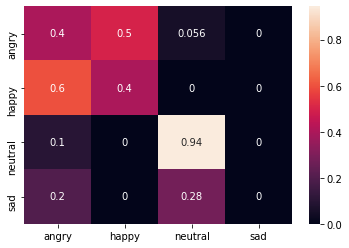

In [ ]:
#test set
from sklearn.metrics import *
Wavenet_paper.load_weights('SAVEE//models//wavenet_paper_loss_1.h5')
cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(Wavenet_paper.predict(X_test).reshape(45,4),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(Wavenet_paper.predict(X_test).reshape(45,4),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

# Wavenet 5

In [ ]:
# hyper-parameters

def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention

n_filters = 64
filter_width = 2
dilation_rates = [2**i for i in range(3)]  
sr = 16000

history_seq = Input(shape=(int(sr*time), 1))
x = history_seq


x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
x = AveragePooling1D()(x)

x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
x = AveragePooling1D()(x)

x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
x = AveragePooling1D()(x)
skips = []
for dilation_rate in dilation_rates:
    
    
    x = Conv1D(32, 1, padding='same', activation='relu')(x) 
    
    # filter
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gate
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # combine filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(32, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    
    skips.append(z)


out = Activation('relu')(Add()(skips))

out = AveragePooling1D(8000)(out)
out = self_attention(out)

out = Conv1D(4,1,activation='softmax')(out)
out = Reshape((4,1))(out)

Wavenet5 = Model(history_seq, out)
Wavenet5.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 80000, 1)]   0                                            
__________________________________________________________________________________________________
conv1d_204 (Conv1D)             (None, 80000, 8)     48          input_7[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 80000, 8)     0           conv1d_204[0][0]                 
__________________________________________________________________________________________________
conv1d_205 (Conv1D)             (None, 80000, 8)     328         leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [ ]:
Wavenet5.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('SAVEE//models//wavenet5_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('SAVEE//models//wavenet5_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = Wavenet5.fit(X_train,Y_train, batch_size=16,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
13/13 [==============================] - 5s 214ms/step - loss: 1.3765 - accuracy: 0.7500 - val_loss: 1.3737 - val_accuracy: 0.7500

Epoch 00001: val_loss improved from inf to 1.37371, saving model to SAVEE//models/wavenet5_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.75000, saving model to SAVEE//models/wavenet5_acc.h5
Epoch 2/30
13/13 [==============================] - 2s 130ms/step - loss: 1.3207 - accuracy: 0.7500 - val_loss: 1.4206 - val_accuracy: 0.7500

Epoch 00002: val_loss did not improve from 1.37371

Epoch 00002: val_accuracy did not improve from 0.75000
Epoch 3/30
13/13 [==============================] - 2s 129ms/step - loss: 1.2769 - accuracy: 0.7466 - val_loss: 1.3697 - val_accuracy: 0.7500

Epoch 00003: val_loss improved from 1.37371 to 1.36969, saving model to SAVEE//models/wavenet5_loss.h5

Epoch 00003: val_accuracy did not improve from 0.75000
Epoch 4/30
13/13 [==============================] - 2s 130ms/step - loss: 1.2440 - accuracy: 0.7511 - 

In [ ]:
Wavenet5.load_weights('SAVEE//models//wavenet5_loss.h5')
print(Wavenet5.evaluate(X_test,Y_test))
Wavenet5.load_weights('SAVEE//models//wavenet5_acc.h5')
Wavenet5.evaluate(X_test,Y_test)

2/2 [==============================] - 1s 187ms/step - loss: 0.6811 - accuracy: 0.8222
[0.6810513138771057, 0.8222222328186035]
2/2 [==============================] - 0s 42ms/step - loss: 0.6939 - accuracy: 0.8333


[0.69385826587677, 0.8333333134651184]

F1 SCORE: 0.43819444444444444
Kappa: 0.3427931292008962
Accuracy: 0.5454545454545454
Jaccard Score: 0.2983019136036377
Precision: 0.6129310344827585
Recall: 0.4684065934065934


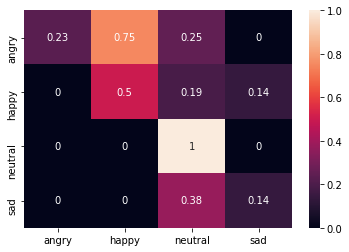

In [ ]:
Wavenet5.load_weights('SAVEE//models//wavenet5_loss.h5')
#test set
from sklearn.metrics import *
cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(Wavenet5.predict(X_test).reshape(44,4),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(Wavenet5.predict(X_test).reshape(44,4),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


# Hand Engineered

In [ ]:
ann_model = Sequential(name='Input_Layer')
ann_model.add(Dense(128,name='Dense_1'))
ann_model.add(LeakyReLU(name='Leaky_Relu_Activation_1'))
ann_model.add(Dense(32,name='Dense_2'))
ann_model.add(LeakyReLU(name = 'LEaky_Relu_Activation_2'))
ann_model.add(Dense(4, activation='softmax',name='Output_Layer'))

ann_model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
ann_model.fit(X_train_features,
          Y_train_features,
          epochs=30,
          batch_size=8,
          validation_data=(X_val_features, Y_val_features))

Epoch 1/30
26/26 [==============================] - 0s 8ms/step - loss: 1.1713 - accuracy: 0.4657 - val_loss: 0.9180 - val_accuracy: 0.5682
Epoch 2/30
26/26 [==============================] - 0s 3ms/step - loss: 0.7337 - accuracy: 0.7001 - val_loss: 0.8478 - val_accuracy: 0.6136
Epoch 3/30
26/26 [==============================] - 0s 3ms/step - loss: 0.6037 - accuracy: 0.7174 - val_loss: 0.8252 - val_accuracy: 0.5909
Epoch 4/30
26/26 [==============================] - 0s 3ms/step - loss: 0.5303 - accuracy: 0.7872 - val_loss: 0.8258 - val_accuracy: 0.6136
Epoch 5/30
26/26 [==============================] - 0s 3ms/step - loss: 0.5071 - accuracy: 0.7651 - val_loss: 0.8142 - val_accuracy: 0.6364
Epoch 6/30
26/26 [==============================] - 0s 3ms/step - loss: 0.4539 - accuracy: 0.8493 - val_loss: 0.8576 - val_accuracy: 0.6136
Epoch 7/30
26/26 [==============================] - 0s 4ms/step - loss: 0.3826 - accuracy: 0.8598 - val_loss: 0.8214 - val_accuracy: 0.6591
Epoch 8/30
26/26 [==

In [ ]:
ann_model.load_weights('SAVEE//models//ANN_loss.h5')
print(ann_model.evaluate(X_test_features,Y_test_features))
ann_model.load_weights('SAVEE//models//ANN_acc.h5')
ann_model.evaluate(X_test_features,Y_test_features)

2/2 [==============================] - 0s 5ms/step - loss: 0.5076 - accuracy: 0.7333
[0.5076161623001099, 0.7333333492279053]
2/2 [==============================] - 0s 6ms/step - loss: 0.5177 - accuracy: 0.7556


[0.5177391767501831, 0.7555555701255798]

2/2 [==============================] - 0s 5ms/step - loss: 0.5177 - accuracy: 0.7556
[0.5177391767501831, 0.7555555701255798]
F1 SCORE: 0.7137040887040886
Kappa: 0.6564885496183206
Accuracy: 0.7555555555555555
Jaccard Score: 0.5770833333333333
Precision: 0.7415413533834587
Recall: 0.7146825396825398


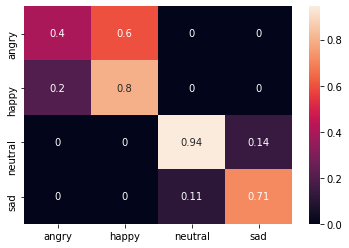

In [ ]:

ann_model.load_weights('SAVEE//models//ANN_acc.h5')
ann_model.evaluate(X_test_features,Y_test_features)

print(ann_model.evaluate(X_test_features,Y_test_features))
g = Y_test_features
p = np.argmax(ann_model.predict(X_test_features),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(Y_test_features,np.argmax(ann_model.predict(X_test_features),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

# Ensembled

In [ ]:
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)

  #out = Conv1D(4,1,activation='softmax')(out)
  #out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (26))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  #out2 = Dense(4)(layer2)
  #out2 = Reshape((4,1))(out2)

  output_layer = Average()([out,layer3])
  output_layer = Flatten()(output_layer)
  output_layer = Dense(4,activation='softmax')(output_layer)
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled = Wavenet()
ensembled.summary()


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 80000, 1)]   0                                            
__________________________________________________________________________________________________
conv1d_226 (Conv1D)             (None, 80000, 8)     48          input_8[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_6 (LeakyReLU)       (None, 80000, 8)     0           conv1d_226[0][0]                 
__________________________________________________________________________________________________
conv1d_227 (Conv1D)             (None, 80000, 8)     328         leaky_re_lu_6[0][0]              
____________________________________________________________________________________________

In [ ]:
ensembled.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('SAVEE//models//ensembled_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('SAVEE//models//ensembled_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ensembled.fit([X_train,X_train_features],Y_train, batch_size=16,validation_data=([X_val,X_val_features], Y_val),epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
13/13 [==============================] - 4s 167ms/step - loss: 0.5182 - accuracy: 0.7903 - val_loss: 0.8266 - val_accuracy: 0.6136

Epoch 00001: val_loss improved from inf to 0.82656, saving model to SAVEE//models/ensembled_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.61364, saving model to SAVEE//models/ensembled_acc.h5
Epoch 2/30
13/13 [==============================] - 2s 129ms/step - loss: 0.4469 - accuracy: 0.8337 - val_loss: 0.8040 - val_accuracy: 0.6364

Epoch 00002: val_loss improved from 0.82656 to 0.80405, saving model to SAVEE//models/ensembled_loss.h5

Epoch 00002: val_accuracy improved from 0.61364 to 0.63636, saving model to SAVEE//models/ensembled_acc.h5
Epoch 3/30
13/13 [==============================] - 2s 130ms/step - loss: 0.4295 - accuracy: 0.8428 - val_loss: 0.7901 - val_accuracy: 0.5682

Epoch 00003: val_loss improved from 0.80405 to 0.79011, saving model to SAVEE//models/ensembled_loss.h5

Epoch 00003: val_accuracy did not improve from 0.

In [ ]:
ensembled.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
ensembled.load_weights("SAVEE//models/ensembled_loss.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))

ensembled.load_weights("SAVEE//models/ensembled_acc.h5")
ensembled.evaluate([X_test,X_test_features],Y_test)

2/2 [==============================] - 1s 172ms/step - loss: 0.4318 - accuracy: 0.8546
[0.4504070580005646, 0.8444444537162781]
2/2 [==============================] - 0s 41ms/step - loss: 0.4643 - accuracy: 0.8222


[0.4642829895019531, 0.8222222328186035]

2/2 [==============================] - 0s 56ms/step - loss: 0.4504 - accuracy: 0.8444
[0.4504070580005646, 0.8444444537162781]
F1 SCORE: 0.8198621553884711
Kappa: 0.7797202797202797
Accuracy: 0.8444444444444444
Jaccard Score: 0.7032509157509158
Precision: 0.8512626262626263
Recall: 0.8035714285714286


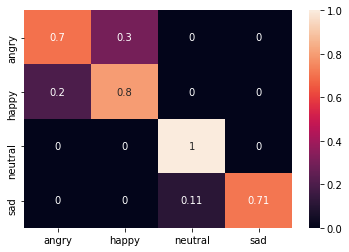

In [ ]:
ensembled.load_weights("SAVEE//models/ensembled_loss.h5")
#test set

print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

# Ensembled Concatenate

In [ ]:
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)

  #out = Conv1D(4,1,activation='softmax')(out)
  #out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (26))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  #out2 = Dense(4)(layer2)
  #out2 = Reshape((4,1))(out2)

  output_layer = Concatenate()([out,layer3])
  output_layer = Flatten()(output_layer)
  output_layer = Dense(4,activation='softmax')(output_layer)
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled_conc = Wavenet()
ensembled_conc.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 80000, 1)]   0                                            
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 80000, 8)     48          input_5[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)       (None, 80000, 8)     0           conv1d_21[0][0]                  
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 80000, 8)     328         leaky_re_lu_8[0][0]              
____________________________________________________________________________________________

In [ ]:
ensembled_conc.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('SAVEE//models//ensembled_conc_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('SAVEE//models//ensembled_conc_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ensembled_conc.fit([X_train,X_train_features],Y_train, batch_size=16,validation_data=([X_val,X_val_features], Y_val),epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
13/13 [==============================] - 7s 332ms/step - loss: 1.3302 - accuracy: 0.3493 - val_loss: 1.0904 - val_accuracy: 0.5227

Epoch 00001: val_loss improved from inf to 1.09043, saving model to SAVEE//models/ensembled_conc_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.52273, saving model to SAVEE//models/ensembled_conc_acc.h5
Epoch 2/30
13/13 [==============================] - 4s 279ms/step - loss: 1.0058 - accuracy: 0.5847 - val_loss: 0.9850 - val_accuracy: 0.5682

Epoch 00002: val_loss improved from 1.09043 to 0.98495, saving model to SAVEE//models/ensembled_conc_loss.h5

Epoch 00002: val_accuracy improved from 0.52273 to 0.56818, saving model to SAVEE//models/ensembled_conc_acc.h5
Epoch 3/30
13/13 [==============================] - 4s 282ms/step - loss: 0.8443 - accuracy: 0.6260 - val_loss: 0.9218 - val_accuracy: 0.5909

Epoch 00003: val_loss improved from 0.98495 to 0.92183, saving model to SAVEE//models/ensembled_conc_loss.h5

Epoch 00003: val_accurac

In [ ]:

ensembled_conc.load_weights("SAVEE//models/ensembled_conc_loss.h5")
print(ensembled_conc.evaluate([X_test,X_test_features],Y_test))

ensembled_conc.load_weights("SAVEE//models/ensembled_conc_acc.h5")
ensembled_conc.evaluate([X_test,X_test_features],Y_test)

2/2 [==============================] - 1s 325ms/step - loss: 0.5365 - accuracy: 0.7333
[0.5365428328514099, 0.7333333492279053]
2/2 [==============================] - 0s 93ms/step - loss: 0.5365 - accuracy: 0.7333


[0.5365428328514099, 0.7333333492279053]

2/2 [==============================] - 0s 112ms/step - loss: 0.5705 - accuracy: 0.7556
[0.5705287456512451, 0.7555555701255798]
F1 SCORE: 0.7323418003565063
Kappa: 0.6666666666666667
Accuracy: 0.7555555555555555
Jaccard Score: 0.5842105263157894
Precision: 0.7523809523809525
Recall: 0.7587301587301587


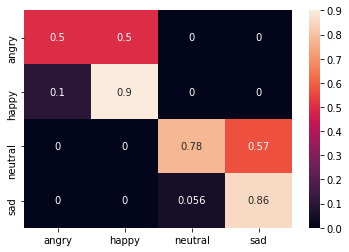

In [ ]:
#test set
print(ensembled_conc.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled_conc.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled_conc.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())


# New Ensembled

In [ ]:
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)


  out = Conv1D(4,1,activation='softmax')(out)
  out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (26))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  out2 = Dense(4,activation = 'softmax')(layer3)
  out2 = Reshape((4,1))(out2)

  output_layer = Average()([out1,out2])
  
  
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled_new = Wavenet()
ensembled_new.summary()


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 80000, 1)]   0                                            
__________________________________________________________________________________________________
conv1d_152 (Conv1D)             (None, 80000, 8)     48          input_16[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_54 (LeakyReLU)      (None, 80000, 8)     0           conv1d_152[0][0]                 
__________________________________________________________________________________________________
conv1d_153 (Conv1D)             (None, 80000, 8)     328         leaky_re_lu_54[0][0]             
____________________________________________________________________________________________

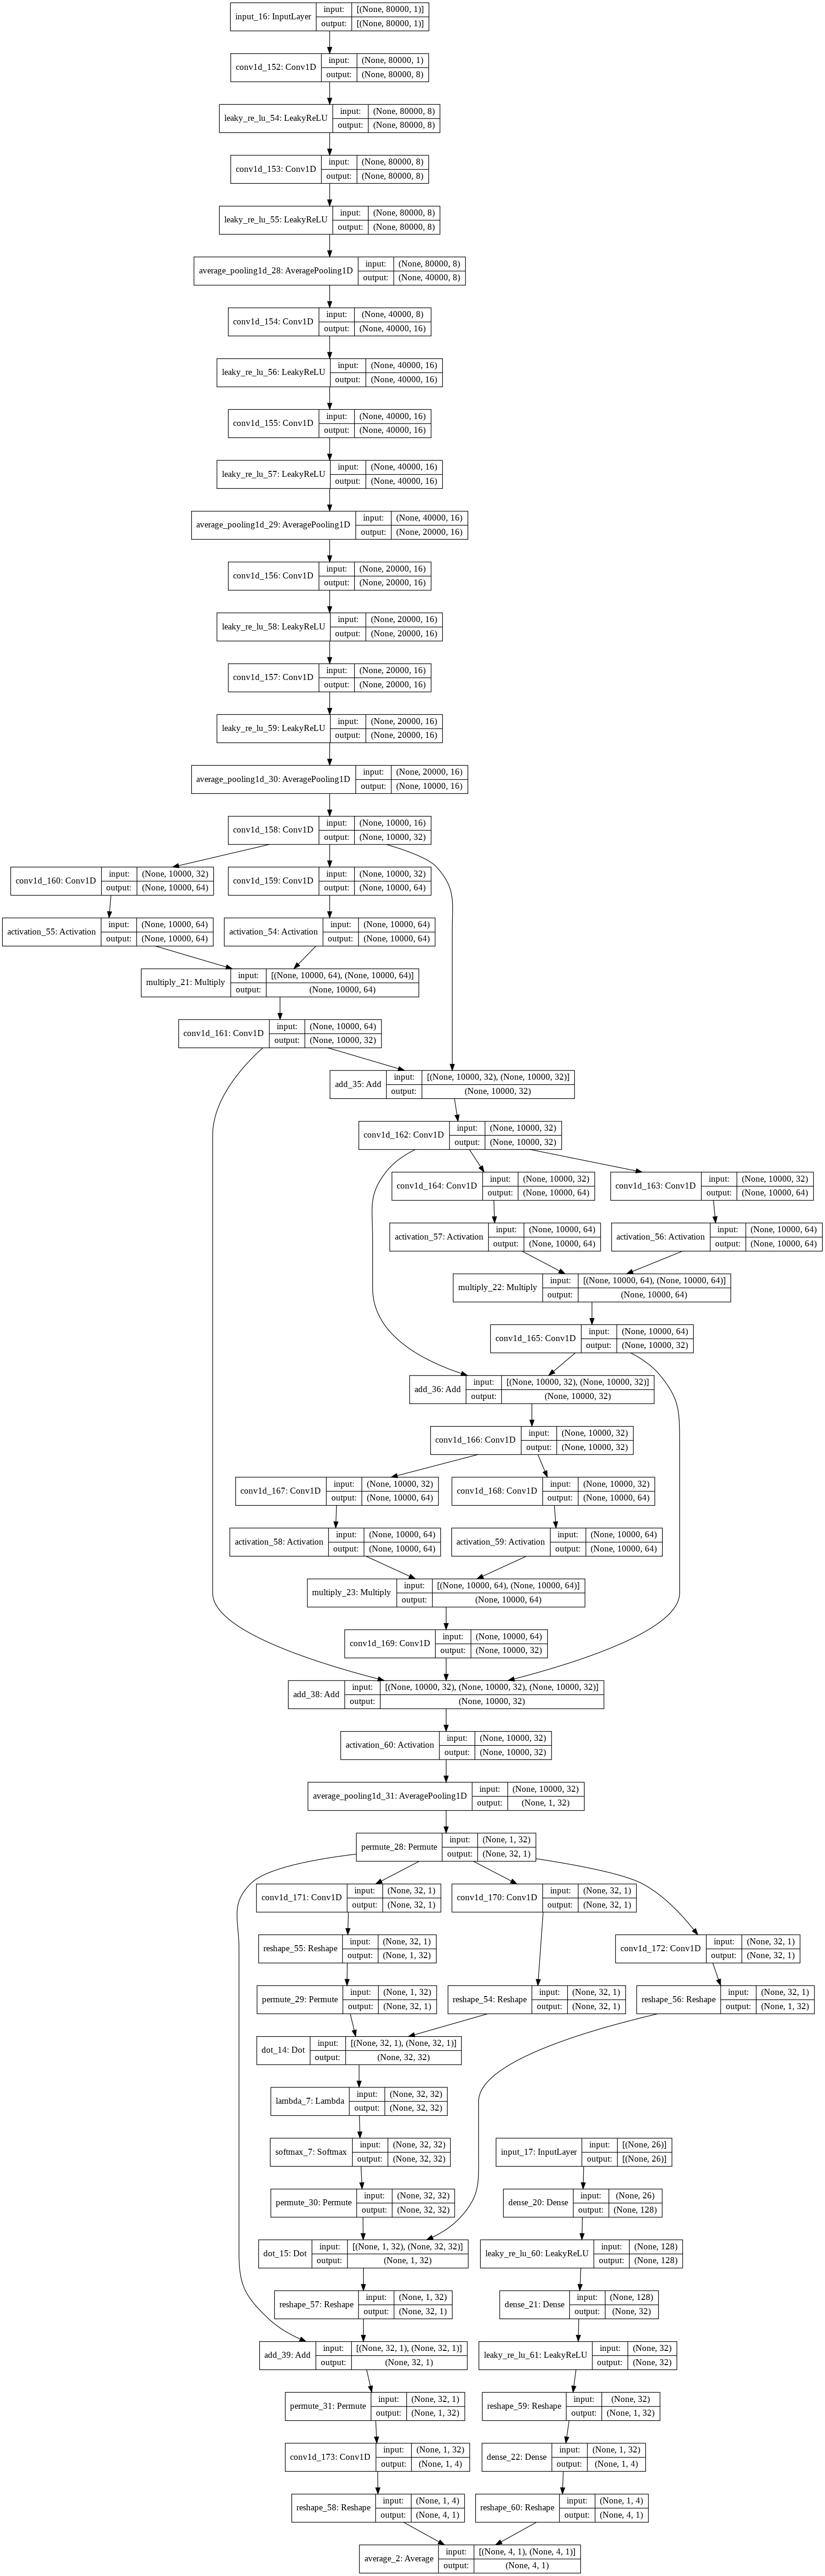

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(ensembled_new,show_shapes=True)

In [ ]:
ensembled_new.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('SAVEE//models//ensembled_new_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('SAVEE//models//ensembled_new_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ensembled_new.fit([X_train,X_train_features],Y_train, batch_size=16,validation_data=([X_val,X_val_features], Y_val),epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
13/13 [==============================] - 8s 340ms/step - loss: 1.3607 - accuracy: 0.7499 - val_loss: 1.2224 - val_accuracy: 0.7784

Epoch 00001: val_loss improved from inf to 1.22239, saving model to SAVEE//models/ensembled_new_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.77841, saving model to SAVEE//models/ensembled_new_acc.h5
Epoch 2/30
13/13 [==============================] - 4s 284ms/step - loss: 1.1002 - accuracy: 0.7951 - val_loss: 1.1937 - val_accuracy: 0.7670

Epoch 00002: val_loss improved from 1.22239 to 1.19370, saving model to SAVEE//models/ensembled_new_loss.h5

Epoch 00002: val_accuracy did not improve from 0.77841
Epoch 3/30
13/13 [==============================] - 4s 282ms/step - loss: 1.0039 - accuracy: 0.8230 - val_loss: 1.1244 - val_accuracy: 0.7898

Epoch 00003: val_loss improved from 1.19370 to 1.12444, saving model to SAVEE//models/ensembled_new_loss.h5

Epoch 00003: val_accuracy improved from 0.77841 to 0.78977, saving model to SAVEE//mo

In [ ]:

ensembled_new.load_weights("SAVEE//models/ensembled_new_loss.h5")
print(ensembled_new.evaluate([X_test,X_test_features],Y_test))

ensembled_new.load_weights("SAVEE//models/ensembled_new_acc.h5")
ensembled_new.evaluate([X_test,X_test_features],Y_test)

2/2 [==============================] - 0s 108ms/step - loss: 0.5234 - accuracy: 0.8889
[0.5234493613243103, 0.8888888955116272]
2/2 [==============================] - 0s 97ms/step - loss: 0.5663 - accuracy: 0.8944


[0.5662851333618164, 0.894444465637207]

(45, 4, 1)


2/2 [==============================] - 0s 115ms/step - loss: 0.5663 - accuracy: 0.8944
[0.5662851333618164, 0.894444465637207]
F1 SCORE: 0.7446428571428572
Kappa: 0.6930422919508867
Accuracy: 0.7777777777777778
Jaccard Score: 0.6041666666666666
Precision: 0.8039215686274509
Recall: 0.7726190476190476


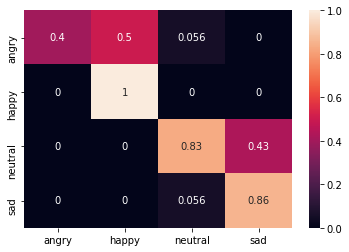

In [ ]:
#test set
print(ensembled_new.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled_new.predict([X_test,X_test_features]).reshape(Y_test.shape),axis = -1)

g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled_new.predict([X_test,X_test_features]).reshape(Y_test.shape),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())


# Ensembled New 2

In [ ]:
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)


  out = Conv1D(4,1,activation='softmax')(out)
  #out1 = Flatten()(out)
  out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (26))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  out2 = Dense(4,activation = 'softmax')(layer3)
  out2 = Reshape((4,1))(out2)
  #out2 = Flatten()(out2)
  #print(out1.shape,out2.shape)

  output_layer = Concatenate(axis = -1)([out1,out2])
  output_layer = Dense(1, use_bias=False)(output_layer)
  
  
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled_new2 = Wavenet()
ensembled_new2.summary()


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 80000, 1)]   0                                            
__________________________________________________________________________________________________
conv1d_220 (Conv1D)             (None, 80000, 8)     48          input_21[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_80 (LeakyReLU)      (None, 80000, 8)     0           conv1d_220[0][0]                 
__________________________________________________________________________________________________
conv1d_221 (Conv1D)             (None, 80000, 8)     328         leaky_re_lu_80[0][0]             
____________________________________________________________________________________________

In [ ]:
ensembled_new2.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('SAVEE//models//ensembled_new2_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('SAVEE//models//ensembled_new2_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ensembled_new2.fit([X_train,X_train_features],Y_train, batch_size=16,validation_data=([X_val,X_val_features], Y_val),epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
13/13 [==============================] - 4s 171ms/step - loss: 1.3863 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 1.38629, saving model to SAVEE//models/ensembled_new2_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.25000, saving model to SAVEE//models/ensembled_new2_acc.h5
Epoch 2/30
13/13 [==============================] - 2s 129ms/step - loss: 1.3863 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2500

Epoch 00002: val_loss did not improve from 1.38629

Epoch 00002: val_accuracy did not improve from 0.25000
Epoch 3/30
13/13 [==============================] - 2s 131ms/step - loss: 1.3863 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2500

Epoch 00003: val_loss did not improve from 1.38629

Epoch 00003: val_accuracy did not improve from 0.25000
Epoch 4/30
13/13 [==============================] - 2s 130ms/step - loss: 1.3863 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2500


In [ ]:
ensembled_new2.load_weights("SAVEE//models/ensembled_new2_loss.h5")
print(ensembled_new2.predict([X_test,X_test_features]))

[[[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [

In [ ]:

ensembled_new2.load_weights("SAVEE//models/ensembled_new2_loss.h5")
print(ensembled_new2.evaluate([X_test,X_test_features],Y_test))

ensembled_new2.load_weights("SAVEE//models/ensembled_new2_acc.h5")
ensembled_new2.evaluate([X_test,X_test_features],Y_test)

2/2 [==============================] - 1s 189ms/step - loss: 0.4898 - accuracy: 0.7500
[0.48980042338371277, 0.75]
2/2 [==============================] - 0s 45ms/step - loss: 0.9931 - accuracy: 0.7500


[0.9930972456932068, 0.75]

In [ ]:
#test set
print(ensembled_new.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled_new.predict([X_test,X_test_features]).reshape(Y_test.shape),axis = -1)

g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled_new.predict([X_test,X_test_features]).reshape(Y_test.shape),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())


# Feature Selection

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


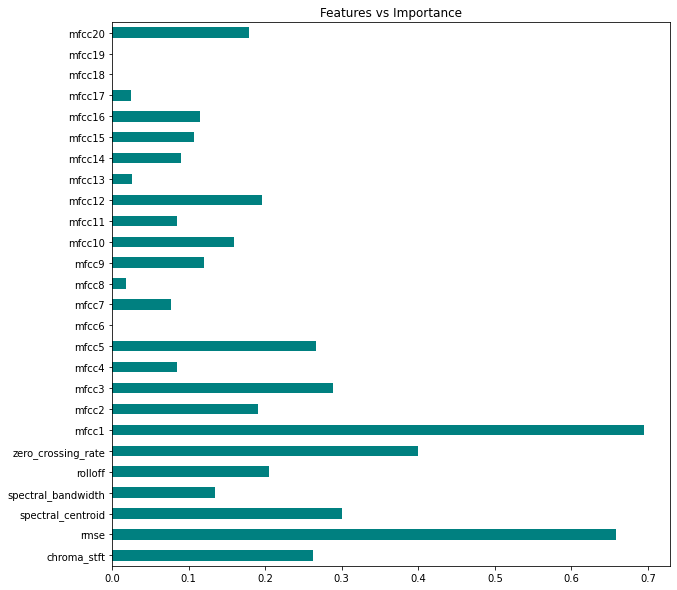

In [ ]:
importances = feature_selection.mutual_info_classif(X_train_features,Y_train_features)
feat_importances = pd.Series(importances,data.columns[0:len(data.columns)-1])
plt.figure(figsize = (10,10))
feat_importances.plot(kind = 'barh',color = 'teal')
plt.title("Features vs Importance")
plt.show()

# CNN

In [ ]:
cnn_model = Sequential(name='Convolutional_Neural_Network')

cnn_model.add(Conv2D(filters=16,
                     kernel_size=(3,3),
                     input_shape=(max_x,max_y,1),name = "Input_Convolution_Layer"))
cnn_model.add(LeakyReLU( name = "Leaky_Relu_Activation_1"))
# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4),name = 'Max_Pooling_1'))

# Adding convolutional layer
cnn_model.add(Conv2D(filters=32,
                     kernel_size=(3,3),name = "Convolution_Layer_2"
                     ))
cnn_model.add(LeakyReLU(name = "Leaky_Relu_Activation_2"))
# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4),name = 'Max_Pooling_2'))

# Adding a flattened layer to input our image data
cnn_model.add(Flatten(name = 'Flatten'))

# Adding a dense layer with 64 neurons
cnn_model.add(Dense(64,name = 'Dense_1' ))
cnn_model.add(LeakyReLU())

# Adding a dropout layer for regularization
cnn_model.add(Dropout(0.25,name = 'Dropout'))

# Adding an output layer
cnn_model.add(Dense(4, activation='softmax',name = 'Output_Layer'))

# Compiling our neural network
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model_checkpoint = ModelCheckpoint(f'SAVEE//models//CNN.h5', monitor='val_loss',verbose=1, save_best_only=True)
# Fitting our neural network
history = cnn_model.fit(X_train_spec,
                        Y_train_spec, 
                        batch_size=16,
                        validation_data=(X_val_spec, Y_val_spec),
                        epochs=30,callbacks = model_checkpoint)

Epoch 1/30
13/13 [==============================] - 1s 21ms/step - loss: 1.7586 - accuracy: 0.3826 - val_loss: 1.4173 - val_accuracy: 0.2955

Epoch 00001: val_loss improved from inf to 1.41731, saving model to SAVEE//models/CNN.h5
Epoch 2/30
13/13 [==============================] - 0s 10ms/step - loss: 1.2577 - accuracy: 0.4205 - val_loss: 1.5033 - val_accuracy: 0.3182

Epoch 00002: val_loss did not improve from 1.41731
Epoch 3/30
13/13 [==============================] - 0s 10ms/step - loss: 1.1635 - accuracy: 0.4753 - val_loss: 1.4821 - val_accuracy: 0.3409

Epoch 00003: val_loss did not improve from 1.41731
Epoch 4/30
13/13 [==============================] - 0s 10ms/step - loss: 1.0438 - accuracy: 0.5688 - val_loss: 1.4075 - val_accuracy: 0.2955

Epoch 00004: val_loss improved from 1.41731 to 1.40753, saving model to SAVEE//models/CNN.h5
Epoch 5/30
13/13 [==============================] - 0s 10ms/step - loss: 1.0073 - accuracy: 0.5868 - val_loss: 1.4378 - val_accuracy: 0.3409

Epoch 

In [ ]:
cnn_model.load_weights('SAVEE//models//CNN.h5')
cnn_model.evaluate(X_test_spec,Y_test_spec)

2/2 [==============================] - 0s 8ms/step - loss: 1.3995 - accuracy: 0.4222


[1.3995054960250854, 0.42222222685813904]

F1 SCORE: 0.37329850859262625
Kappa: 0.20136518771331058
Accuracy: 0.4222222222222222
Jaccard Score: 0.2427177601809955
Precision: 0.4018796992481203
Recall: 0.3956349206349206


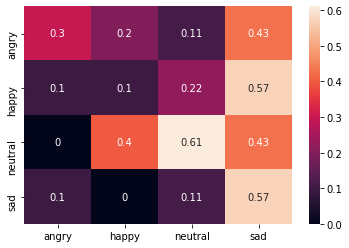

In [ ]:
#test set

g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(cnn_model.predict(X_test_spec),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(cnn_model.predict(X_test_spec),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

# Paper_1

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 8
srk = 44100
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = srk)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "SAVEE//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "SAVEE//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "SAVEE//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (207, 352800, 1) (207, 4)
Test Data (45, 352800, 1) (45, 4)
Val Data (44, 352800, 1) (44, 4)


In [ ]:
def paper_model():
  inp = Input((352800,1))
  l1 = BatchNormalization()(Conv1D(32,21,activation='relu',padding = 'same')(inp))
  m1 = MaxPool1D(2)(l1)

  l2 = BatchNormalization()(Conv1D(64,19,activation='relu',padding = 'same')(m1))
  m2 = MaxPool1D(2)(l2)

  l3 = BatchNormalization()(Conv1D(128,17,activation='relu',padding = 'same')(m2))
  m3 = MaxPool1D(2)(l3)


  l4 = BatchNormalization()(Conv1D(256,15,activation='relu',padding = 'same')(m3))
  m4 = MaxPool1D(2)(l4)

  l5 = BatchNormalization()(Conv1D(512,13,activation='relu',padding = 'same')(m4))
  m5 = MaxPool1D(2)(l5)

  l6 = BatchNormalization()(Conv1D(1024,11,activation='relu',padding = 'same')(m5))
  m6 = MaxPool1D(2)(l6)

  l7 = BatchNormalization()(Conv1D(1024,9,activation='relu',padding = 'same')(m6))
  m7 = GlobalMaxPool1D()(l7)

  fl = Flatten()(m7)
  d1 = Dense(128,activation='relu')(fl)
  out = Dense(4,activation='softmax')(d1)

  return Model(inputs = inp,outputs = out)

m = paper_model()
m.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 352800, 1)]       0         
_________________________________________________________________
conv1d (Conv1D)              (None, 352800, 32)        704       
_________________________________________________________________
batch_normalization (BatchNo (None, 352800, 32)        128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 176400, 32)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 176400, 64)        38976     
_________________________________________________________________
batch_normalization_1 (Batch (None, 176400, 64)        256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 88200, 64)         0     

In [ ]:
m.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('SAVEE//models//paper_1_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('SAVEE//models//paper_1_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = m.fit(X_train,Y_train, batch_size=8,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
26/26 [==============================] - 157s 4s/step - loss: 7.2293 - accuracy: 0.4118 - val_loss: 2.6645 - val_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 2.66446, saving model to SAVEE//models/paper_1_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.25000, saving model to SAVEE//models/paper_1_acc.h5
Epoch 2/30
26/26 [==============================] - 86s 3s/step - loss: 4.5519 - accuracy: 0.4115 - val_loss: 3.3631 - val_accuracy: 0.2727

Epoch 00002: val_loss did not improve from 2.66446

Epoch 00002: val_accuracy improved from 0.25000 to 0.27273, saving model to SAVEE//models/paper_1_acc.h5
Epoch 3/30
26/26 [==============================] - 86s 3s/step - loss: 2.0649 - accuracy: 0.4638 - val_loss: 2.5391 - val_accuracy: 0.2727

Epoch 00003: val_loss improved from 2.66446 to 2.53913, saving model to SAVEE//models/paper_1_loss.h5

Epoch 00003: val_accuracy did not improve from 0.27273
Epoch 4/30
26/26 [==============================] - 86s 3s/s

In [ ]:
m.load_weights('SAVEE//models//paper_1_acc.h5')
print(m.evaluate(X_test,Y_test))
m.load_weights('SAVEE//models//paper_1_loss.h5')
m.evaluate(X_test,Y_test)

2/2 [==============================] - 31s 12s/step - loss: 0.5834 - accuracy: 0.6889
[0.5833597183227539, 0.6888889074325562]
2/2 [==============================] - 4s 1s/step - loss: 0.5834 - accuracy: 0.6889


[0.5833597183227539, 0.6888889074325562]

F1 SCORE: 0.5927318295739348
Kappa: 0.5594405594405594
Accuracy: 0.6888888888888889
Jaccard Score: 0.468529277739804
Precision: 0.6625000000000001
Recall: 0.628968253968254
              precision    recall  f1-score   support

           0       0.50      0.10      0.17        10
           1       0.50      0.90      0.64        10
           2       0.85      0.94      0.89        18
           3       0.80      0.57      0.67         7

    accuracy                           0.69        45
   macro avg       0.66      0.63      0.59        45
weighted avg       0.69      0.69      0.64        45



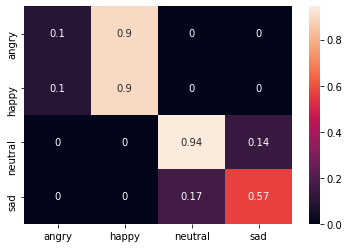

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(m.predict(X_test).reshape(45,4),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(m.predict(X_test).reshape(45,4),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

# Paper_2

In [ ]:
def findmaxsize(rslt_df):

    sizes = []
    for index, row in rslt_df.iterrows(): 
      filename = row['path']

      y, sr = librosa.core.load(filename,sr = 16000)
      #print(y.shape)
      # Computing the mel spectrograms
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      
      spect = librosa.power_to_db(spect, ref=np.max)
      #print(spect.shape)
      
      # Adding the size to the list
      sizes.append(spect.shape)
    print(f'The sizes of all the mel spectrograms in our data set are equal: {len(set(sizes)) == 1}')

    # Checking the max size
    print(f'The maximum size is: {max(sizes)}')


    return max(sizes)


X = pd.read_csv('SAVEE/SAVEE_details.csv',usecols=['labels','path'])
options = ['angry', 'happy','neutral','sad'] 

time = 4
rslt_df = X[X['labels'].isin(options)]

max_x,max_y = findmaxsize(rslt_df)

The sizes of all the mel spectrograms in our data set are equal: False
The maximum size is: (64, 714)


In [ ]:
max_x = 64
max_y = 714
T = 80
print(max_y,T,(int(max_y/T)+1)*T,int(max_y/T)+1)

714 80 720 9


In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}


def label_to_onehot(l):
  onehot = label_dict[l]
  return onehot
def extract_mel_spectrogram(df,max_x = max_x,max_y = (int(max_y/T)+1)*T):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path']
 
      y, sr = librosa.core.load(filename,sr = 16000)
      #print(y.shape)
      # Computing the mel spectrograms
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      
      spect = librosa.power_to_db(spect, ref=np.max)
 
            
      
      if spect.shape[1] != max_y:
                #print('Sizes arent same')
              spect.resize(max_x,max_y, refcheck=False)
      s=[]
      for i in range(int(max_y/T)):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*T:(i+1)*T]
        delta = librosa.feature.delta(q).reshape((max_x,T,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,T,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,T,1))

        z = np.concatenate((q,delta,d_delta),axis = -1)
        #print(z.shape)
        s.append(z)
      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
train_path = "SAVEE//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
#X_train_spec = np.expand_dims(X_train_spec,axis=-1)
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "SAVEE//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
#X_test_spec = np.expand_dims(X_test_spec,axis=-1)
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "SAVEE//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
#X_val_spec = np.expand_dims(X_val_spec,axis=-1)
print(X_val_spec.shape,Y_val_spec.shape)

(207, 9, 64, 80, 3) (207, 4)
(45, 9, 64, 80, 3) (45, 4)
(44, 9, 64, 80, 3) (44, 4)


In [ ]:
import keras
def AlexNet(input_shape):
    
    X_input = Input(input_shape)
    
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X_input)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max2')(X)
    
    X = Reshape((36,256))(X)

    X= LSTM(256,return_sequences=True)(X)
    X= LSTM(256)(X)

    
    #X = Dense(4096, activation = 'relu', name = "fc0")(X)
    
    #X = Dense(4096, activation = 'relu', name = 'fc1')(X) 
    
    

    model = Model(inputs = X_input, outputs = X, name='AlexNet')

    return model

def paper_2():
    input_layer = Input((int(max_y/T)+1,max_x,T,3))
    alex = AlexNet((227,227,3))
    
    for i in range(int(max_y/T)+1):
      #print(input_layer[:,0,:,:,:].shape)
      inp = keras.layers.experimental.preprocessing.Resizing(227,227)(input_layer[:,i,:,:,:])
      
      cnn = alex(inp)

      #cnn = Reshape((1,4096))(cnn)

      if i == 0:
        output_layers = cnn
      else:
        output_layers = Concatenate(axis = 1)([output_layers,cnn])
      
    
    #print(len(output_layers))
    #lstm = LSTM(256,return_sequences=True)(output_layers)
    #lstm = LSTM(256,return_sequences=True)(lstm)
    #lstm = LSTM(256)(lstm)
    
    out = Dense(4,activation='softmax')(output_layers)
    
    
    
    return Model(inputs=input_layer,outputs=out)
p2 = paper_2()
p2.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9, 64, 80, 3 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 64, 80, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 64, 80, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
resizing (Resizing)             (None, 227, 227, 3)  0           tf.__operators__.getitem[0][0]   
______________________________________________________________________________________________

In [ ]:
p2.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('SAVEE//models//paper_2_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('SAVEE//models//paper_2_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = p2.fit(X_train_spec,Y_train_spec, batch_size=8,validation_data=(X_val_spec, Y_val_spec),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
26/26 [==============================] - 81s 910ms/step - loss: 1.6276 - accuracy: 0.3036 - val_loss: 1.5237 - val_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 1.52366, saving model to SAVEE//models/paper_2_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.25000, saving model to SAVEE//models/paper_2_acc.h5
Epoch 2/30
26/26 [==============================] - 14s 546ms/step - loss: 1.3001 - accuracy: 0.4549 - val_loss: 1.4433 - val_accuracy: 0.2045

Epoch 00002: val_loss improved from 1.52366 to 1.44334, saving model to SAVEE//models/paper_2_loss.h5

Epoch 00002: val_accuracy did not improve from 0.25000
Epoch 3/30
26/26 [==============================] - 14s 547ms/step - loss: 1.2923 - accuracy: 0.4653 - val_loss: 1.3995 - val_accuracy: 0.3409

Epoch 00003: val_loss improved from 1.44334 to 1.39953, saving model to SAVEE//models/paper_2_loss.h5

Epoch 00003: val_accuracy improved from 0.25000 to 0.34091, saving model to SAVEE//models/paper_2_acc.h5
E

In [ ]:
p2.load_weights('SAVEE//models//paper_2_acc.h5')
print(p2.evaluate(X_test_spec,Y_test_spec))
p2.load_weights('SAVEE//models//paper_2_loss.h5')
p2.evaluate(X_test_spec,Y_test_spec)

2/2 [==============================] - 2s 811ms/step - loss: 1.1326 - accuracy: 0.5333
[1.132591724395752, 0.5333333611488342]
2/2 [==============================] - 1s 245ms/step - loss: 1.1326 - accuracy: 0.5333


[1.132591724395752, 0.5333333611488342]

F1 SCORE: 0.3706989247311828
Kappa: 0.34100418410041844
Accuracy: 0.5333333333333333
Jaccard Score: 0.2833850931677019
Precision: 0.35357142857142854
Recall: 0.43333333333333335


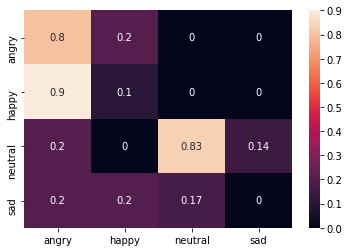

In [ ]:
#test set
#p2.load_weights('SAVEE//models//paper_2_acc.h5')
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p2.predict(X_test_spec),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p2.predict(X_test_spec),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

#Paper 4

In [ ]:
!pip install Signal_Analysis

     |████████████████████████████████| 378kB 6.8MB/s 
  Created wheel for Signal-Analysis: filename=Signal_Analysis-0.1.26-cp37-none-any.whl size=14538 sha256=2f66f262630089ebe3533db7cfedd2d441f76d03db19538b685db861d8a30a0b
  Stored in directory: /root/.cache/pip/wheels/50/06/bb/04aa9ef50b93b5961b9817600ca1ff379f7091e63e09831655
Successfully built Signal-Analysis


In [ ]:
import numpy as np
import pandas as pd

import ast
import os
from tqdm.notebook import tqdm
import time

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Sound Processing
import librosa
from Signal_Analysis.features.signal import get_F_0, get_HNR

# Training Data Preparation
from sklearn.model_selection import train_test_split



import tensorflow as tf
from kapre.utils import Normalization2D
from tensorflow.keras import backend as K
import numpy as np
import librosa.display
import IPython.display as ipd

In [ ]:
NUM_EMOTIONS = 4
N_FFT = 4096
HOP_LENGTH = 1024
EMOTIONS = ['ang', 'hap', 'neu', 'sad']
SR = 16000


def extract_HSF(lld):
    mean_val = lld.mean()
    min_val = lld.min()
    max_val = lld.max()
    var_val = lld.var()
    range_val = np.subtract(max_val, min_val)
    q25_val = np.quantile(lld, 0.25)
    q50_val = np.quantile(lld, 0.5)
    q75_val = np.quantile(lld, 0.75)
    return np.asarray([
        mean_val,
        min_val,
        max_val,
        var_val,
        range_val,
        q25_val,
        q50_val,
        q75_val,
    ])

def extract_LLD_from_subaudio(subaudio, fs):
    # Frame-wise energy
    energy_val = np.sum(np.square(subaudio)) / (subaudio.shape[0] / fs + 0.00000000000001)
    
    # Frame-wise Zero Crossing Rate
    zcr_val = np.sum((subaudio[:-1] * subaudio[1:]) < 0)
    
    return np.asarray([
        energy_val,
        zcr_val,
    ])

def extract_LLD_from_audio(audio, fs):
    # MFCC
    mfcc = librosa.feature.mfcc(audio, fs, n_fft = N_FFT, hop_length = HOP_LENGTH, center = False).transpose()
    mfcc_hsf = extract_HSF(mfcc)
    
    # LPC
    lpc = librosa.lpc(audio, 16)
    
    # Mel-Spectrogram
    spect = librosa.feature.melspectrogram(y = audio, sr = fs, n_fft = N_FFT, hop_length = HOP_LENGTH, center = False)
    spect = librosa.power_to_db(spect, ref = np.max).transpose()
    spect_hsf = extract_HSF(spect)
    
    # Other features
    f0 = get_F_0(audio, fs)[0]
    hnr = get_HNR(audio, fs)
    
    return np.asarray(mfcc), np.asarray(mfcc_hsf), np.asarray(lpc), np.asarray(spect), np.asarray(spect_hsf), np.asarray([f0, hnr])

def extract_LLD(audio, fs):
    #print(audio.shape)
    #print(int((audio.shape[0] - N_FFT) // HOP_LENGTH) + 1)
    num_windows = int((audio.shape[0] - N_FFT) // HOP_LENGTH) + 1
    framewise_lld = np.zeros((num_windows, 2))
    for idx in range(num_windows):
        subaudio = audio[int(idx * HOP_LENGTH): int(idx * HOP_LENGTH + N_FFT)]
        framewise_lld[idx, :] = extract_LLD_from_subaudio(subaudio, fs)
    framewise_lld_hsf = extract_HSF(framewise_lld)
    
    mfcc, mfcc_hsf, lpc, spect, spect_hsf, others = extract_LLD_from_audio(audio, fs)
    
    assert(framewise_lld.shape[0] == mfcc.shape[0])
    assert(mfcc.shape[0] == spect.shape[0])

    rnn_feats = np.concatenate((framewise_lld, mfcc, spect), axis = 1)
    dense_feats = np.concatenate((framewise_lld_hsf, mfcc_hsf, lpc, spect_hsf, others))
    return rnn_feats, dense_feats

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])
  X = []
  Y = []
  for index, row in rslt_df.iterrows(): 
    y = librosa.load(row['path'], mono=True, duration = 30,sr = SR)[0]
    y = librosa.util.fix_length(y,4*SR)
    rnn_feats, dense_feats = extract_LLD(y, SR)
    X.append(rnn_feats)
    Y.append(label_to_onehot(row['labels']))
    #print(rnn_feats.shape)

  X = np.reshape(np.array(X),(len(Y),X[0].shape[0],X[0].shape[1]))
  Y = np.reshape(np.array(Y),(X.shape[0],4))

  return X,Y



train_path = "SAVEE//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "SAVEE//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "SAVEE//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'nump

In [ ]:
X_train = np.expand_dims(X_train,axis = -1)
X_test = np.expand_dims(X_test,axis = -1)
X_val = np.expand_dims(X_val,axis = -1)

X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()
X_val = (X_val - X_val.mean())/X_val.std()

In [ ]:

def RNNSpeechModel(no_of_classes, input_size):
  
  # x = tf.keras.layers.Input((input_len,))
  # x = tf.keras.layers.Reshape((1,-1))(x)
  # m = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, input_len),
  #                      padding='same', sr=sr, n_mels=80,
  #                      fmin=40.0, fmax=sr / 2, power_melgram=1.0,
  #                      return_decibel_melgram=True, trainable_fb=False,
  #                      trainable_kernel=False,
  #                      name='mel_stft')
  # m.trainable = False
  # x = m(x)
  #x = Normalization2D(int_axis=0)(x)
  #x = tf.keras.layers.Permute((2,1,3))(x)

  input = tf.keras.layers.Input((input_size))
  #Bidirectional RNN
  x = tf.keras.layers.Conv2D(10,(5,1),activation='relu',padding = 'same')(input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(1,(5,1),activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Lambda(lambda q: K.squeeze(q, -1))(x)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences = 'true'))(x)
  #x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences = 'true'))(x)

  #Attention unit
  xFirst = tf.keras.layers.Lambda(lambda q: q[:,-1])(x)
  query = tf.keras.layers.Dense(128)(xFirst)
  att_score = tf.keras.layers.Dot(axes=[1,2])([query,x])
  att_score = tf.keras.layers.Softmax()(att_score)

  #weighted pooling
  att_vector = tf.keras.layers.Dot(axes=[1,1])([att_score,x])
  #x = tf.keras.layers.Dense(64,activation='relu')(att_vector)
  #x = tf.keras.layers.Dense(32,activation='relu')(x)
  output = tf.keras.layers.Dense(no_of_classes,activation='softmax')(att_vector)

  model = tf.keras.models.Model(inputs = input,outputs = output)
  return model
  
no_of_classes = 4
input_size = X_train[0].shape
p4 = RNNSpeechModel(no_of_classes,input_size)
p4.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
p4.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 59, 150, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 59, 150, 10)  60          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 59, 150, 10)  40          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 59, 150, 1)   51          batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('SAVEE//models//paper_4_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('SAVEE//models//paper_4_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
p4.fit(X_train,Y_train, batch_size=8,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
26/26 [==============================] - 36s 52ms/step - loss: 1.2200 - acc: 0.4409 - val_loss: 1.3066 - val_acc: 0.2955

Epoch 00001: val_loss improved from inf to 1.30657, saving model to SAVEE//models/paper_4_loss.h5
Epoch 2/30
26/26 [==============================] - 0s 13ms/step - loss: 1.0366 - acc: 0.4365 - val_loss: 1.1777 - val_acc: 0.4545

Epoch 00002: val_loss improved from 1.30657 to 1.17769, saving model to SAVEE//models/paper_4_loss.h5
Epoch 3/30
26/26 [==============================] - 0s 12ms/step - loss: 0.9029 - acc: 0.5679 - val_loss: 1.1830 - val_acc: 0.4773

Epoch 00003: val_loss did not improve from 1.17769
Epoch 4/30
26/26 [==============================] - 0s 11ms/step - loss: 0.7499 - acc: 0.7065 - val_loss: 1.2664 - val_acc: 0.4773

Epoch 00004: val_loss did not improve from 1.17769
Epoch 5/30
26/26 [==============================] - 0s 11ms/step - loss: 0.7061 - acc: 0.7361 - val_loss: 1.3568 - val_acc: 0.4318

Epoch 00005: val_loss did not improve

In [ ]:
p4.load_weights('SAVEE//models//paper_4_loss.h5')
p4.evaluate(X_test,Y_test)

2/2 [==============================] - 0s 42ms/step - loss: 0.5300 - acc: 0.8000


[0.5300206542015076, 0.800000011920929]

F1 SCORE: 0.7662741545893719
Kappa: 0.7216494845360824
Accuracy: 0.8
Jaccard Score: 0.6373205741626794
Precision: 0.7857905982905984
Recall: 0.7753968253968254
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.80      0.70        10
           2       0.94      0.94      0.94        18
           3       0.75      0.86      0.80         7

    accuracy                           0.80        45
   macro avg       0.79      0.78      0.77        45
weighted avg       0.82      0.80      0.80        45



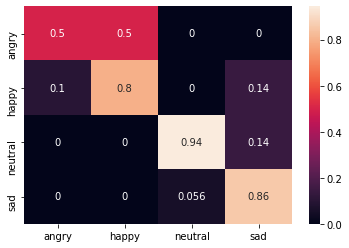

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

# Paper 5

In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}


def label_to_onehot(l):
  #l=l[2:]
  onehot = label_dict[l]
  return onehot


def extract_mel_spectrogram(df,max_x = 64,max_y = 714):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path'] 
      y, sr = librosa.core.load(filename,sr = 16000)
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      spect = librosa.power_to_db(spect, ref=np.max)
 
      if spect.shape[1] != max_y:
              spect.resize(max_x,max_y, refcheck=False)

      s=[]
      for i in range(0,int((max_y-64)/30),1):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*30:64 +i*30]
        #print(q.shape)
        delta = librosa.feature.delta(q).reshape((max_x,64,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,64,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,64,1))

        z = np.concatenate((q,delta,d_delta),axis = -1)
        #print(z.shape)
        s.append(z)
      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
 
train_path = "SAVEE//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
#X_train_spec = np.expand_dims(X_train_spec,axis=-1)
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "SAVEE//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
#X_test_spec = np.expand_dims(X_test_spec,axis=-1)
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "SAVEE//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
#X_val_spec = np.expand_dims(X_val_spec,axis=-1)
print(X_val_spec.shape,Y_val_spec.shape)

(207, 21, 64, 64, 3) (207, 4)
(45, 21, 64, 64, 3) (45, 4)
(44, 21, 64, 64, 3) (44, 4)


In [ ]:
import keras
from sklearn.svm import SVC


def div_L0(num):
    [a, b] = div_L1(num)
    [c, d, e, f] = div_L2(num)

    return [a, b], [c, d, e, f]
def div_L1(num):
    a = num // 2
    b = num - a

    return [a, b]
def div_L2(num):
    [a, b] = div_L1(num)
    [c, d] = div_L1(a)
    [e, f] = div_L1(b)

    return [c, d, e, f]

def lpnorm_pooling(features_Ln):
    '''
    :param features_Ln:
    :param var_p: 1-average pooling, np.inf-max pooling
    :return:
    '''
    var_p = 2.14  # average pooling
#   var_p = np.inf  # max pooling
    lpnorm = tf.norm(features_Ln,ord=var_p,axis=1)
    result = lpnorm * (1/features_Ln.shape[1])**(1/var_p)

    #print(result)
    result = tf.math.reduce_max(features_Ln,axis = 1)
    #result = np.average(features_Ln,axis = 0)
    #print(result)

    return result

def subpart():
    
    input_layer = Input((227,227,3))

    X = keras.layers.experimental.preprocessing.Resizing(227,227)(input_layer)
    
      
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D(2)(X)
    
    X = Flatten()(X)
    
    X = Dense(4096, activation = 'relu', name = "fc0")(X)
    
    X = Dense(4096, activation = 'relu', name = 'fc1')(X) 

    Y = Reshape((1,4096))(X)

    return Model(inputs = input_layer,outputs = Y)





def paper_2():
    input_layer = Input((21,64,64,3))

    sp = subpart()

    for i in range(input_layer.shape[1]):
      #print(input_layer[:,0,:,:,:].shape)
      inp = keras.layers.experimental.preprocessing.Resizing(227,227)(input_layer[:,i,:,:,:])
      output_layer = sp(inp)

      if i == 0:
        output_layers = output_layer
      else:
        output_layers = Concatenate(axis = 1)([output_layers,output_layer])
    
    print(output_layers.shape)
    t,n, d = output_layers.shape
    #rint(X.shape)

    if n == 3:
        features = np.row_stack((X, X[-1]))
    if n == 2:
        features = np.row_stack((X, X))
    if n == 1:
        print(n)
        features = tf.stack((X, X, X, X),axis =1)

    #print(features.shape)
    t,n, d = output_layers.shape

    [a, b], [c, d, e, f] = div_L0(n)

    L0 = lpnorm_pooling(output_layers)
    #print(a,b,c,d,e,f, features.shape)
    L1_1 = lpnorm_pooling(output_layers[:,:a,:])
    #print(features[:,:a,].shape)
    L1_2 = lpnorm_pooling(output_layers[:,a:,:])

    L2_1 = lpnorm_pooling(output_layers[:,:c,:])
    L2_2 = lpnorm_pooling(output_layers[:,c:a,:])
    L2_3 = lpnorm_pooling(output_layers[:,a:a+e,:])
    L2_4 = lpnorm_pooling(output_layers[:,a+e:,:])

    W_L0=1/4;
    W_L1=1/4;
    W_L2=1/2;

    Weights_L = [[W_L0,0,0,0,0,0,0],
                 [0,W_L1,0,0,0,0,0],
                 [0,0,W_L1,0,0,0,0],
                 [0,0,0,W_L2,0,0,0],
                 [0,0,0,0,W_L2,0,0],
                 [0,0,0,0,0,W_L2,0],
                 [0,0,0,0,0,0,W_L2]]

    features_Vp = Concatenate(axis =1)([W_L0*L0, W_L1*L1_1, W_L1*L1_2, W_L2*L2_1, W_L2*L2_2, W_L2*L2_3, W_L2*L2_4])

    op = Dense(4,activation = 'softmax',kernel_regularizer=keras.regularizers.l2(0.01))(features_Vp)
    #features_Up = np.matmul(Weights_L,features_Vp)

    return Model(inputs=input_layer,outputs=op)

p5 = paper_2()
p5.summary()

(None, 21, 4096)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 21, 64, 64,  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_13 (Sl (None, 64, 64, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_14 (Sl (None, 64, 64, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
resizing_9 (Resizing)           (None, 227, 227, 3)  0           tf.__operators__.getitem_13[0][0]
___________________________________________________________________________

In [ ]:
p5.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('SAVEE//models//paper_5_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('SAVEE//models//paper_5_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = p5.fit(X_train_spec,Y_train_spec, batch_size=8,validation_data=(X_val_spec, Y_val_spec),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
26/26 [==============================] - 19s 455ms/step - loss: 148.0856 - accuracy: 0.2856 - val_loss: 1.4055 - val_accuracy: 0.3182

Epoch 00001: val_loss improved from inf to 1.40548, saving model to SAVEE//models/paper_5_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.31818, saving model to SAVEE//models/paper_5_acc.h5
Epoch 2/30
26/26 [==============================] - 10s 389ms/step - loss: 1.3439 - accuracy: 0.4204 - val_loss: 1.3896 - val_accuracy: 0.3182

Epoch 00002: val_loss improved from 1.40548 to 1.38958, saving model to SAVEE//models/paper_5_loss.h5

Epoch 00002: val_accuracy did not improve from 0.31818
Epoch 3/30
26/26 [==============================] - 10s 392ms/step - loss: 1.3172 - accuracy: 0.4050 - val_loss: 1.3976 - val_accuracy: 0.3182

Epoch 00003: val_loss did not improve from 1.38958

Epoch 00003: val_accuracy did not improve from 0.31818
Epoch 4/30
26/26 [==============================] - 10s 392ms/step - loss: 1.3222 - accuracy: 0.3776

In [ ]:
p5.load_weights('SAVEE//models//paper_5_acc.h5')
print(p5.evaluate(X_test_spec,Y_test_spec))
p5.load_weights('SAVEE//models//paper_5_loss.h5')
p5.evaluate(X_test_spec,Y_test_spec)

2/2 [==============================] - 1s 152ms/step - loss: 0.9817 - accuracy: 0.5556
[0.981687605381012, 0.5555555820465088]
2/2 [==============================] - 1s 162ms/step - loss: 0.9531 - accuracy: 0.6222


[0.9531041383743286, 0.6222222447395325]

F1 SCORE: 0.5618368700265253
Kappa: 0.4865771812080537
Accuracy: 0.6222222222222222
Jaccard Score: 0.41036682615629977
Precision: 0.6236424394319131
Recall: 0.6095238095238096
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.67      0.20      0.31        10
           2       0.86      0.67      0.75        18
           3       0.44      0.57      0.50         7

    accuracy                           0.62        45
   macro avg       0.62      0.61      0.56        45
weighted avg       0.68      0.62      0.60        45



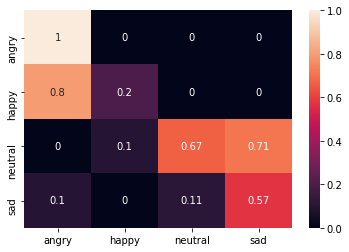

In [ ]:
#test set
#p2.load_weights('TESS//models//paper_2_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

# paper 6

In [ ]:
max_x = 96
max_y = 714
T = 64
print(max_y,T,(int(max_y/T)+1)*T,int(max_y/T)+1)

714 64 768 12


In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}


def label_to_onehot(l):
  onehot = label_dict[l]
  return onehot
def extract_mel_spectrogram(df,max_x = max_x,max_y = (int(max_y/T)+1)*T):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path']
 
      y, sr = librosa.core.load(filename,sr = 16000)
      #print(y.shape)
      # Computing the mel spectrograms
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = max_x)
      
      spect = librosa.power_to_db(spect, ref=np.max)
 
            
      
      if spect.shape[1] != max_y:
                #print('Sizes arent same')
              spect.resize(max_x,max_y, refcheck=False)
      s=[]
      for i in range(int(max_y/T)):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*T:(i+1)*T]
        delta = librosa.feature.delta(q).reshape((max_x,T,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,T,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,T,1))

        z = np.concatenate((q,delta,d_delta),axis = -1)
        #print(z.shape)
        s.append(z)
      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
train_path = "SAVEE//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
#X_train_spec = np.expand_dims(X_train_spec,axis=-1)
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "SAVEE//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
#X_test_spec = np.expand_dims(X_test_spec,axis=-1)
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "SAVEE//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
#X_val_spec = np.expand_dims(X_val_spec,axis=-1)
print(X_val_spec.shape,Y_val_spec.shape)

(207, 12, 96, 64, 3) (207, 4)
(45, 12, 96, 64, 3) (45, 4)
(44, 12, 96, 64, 3) (44, 4)


# Jan 2022

## ensembled

In [ ]:
time = 5
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)

  #out = Conv1D(4,1,activation='softmax')(out)
  #out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (26))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  #out2 = Dense(4)(layer2)
  #out2 = Reshape((4,1))(out2)

  output_layer = Average()([out,layer3])
  output_layer = Flatten()(output_layer)
  output_layer = Dense(4,activation='softmax')(output_layer)
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled = Wavenet()
ensembled.summary()

ensembled.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 80000, 1)]   0           []                               
                                                                                                  
 conv1d_43 (Conv1D)             (None, 80000, 8)     48          ['input_5[0][0]']                
                                                                                                  
 leaky_re_lu_16 (LeakyReLU)     (None, 80000, 8)     0           ['conv1d_43[0][0]']              
                                                                                                  
 conv1d_44 (Conv1D)             (None, 80000, 8)     328         ['leaky_re_lu_16[0][0]']         
                                                                                            

## Testing on Emo-db ( manipulated) 

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 5
def label_to_onehot(l):
    l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "EMO_DB//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "EMO_DB//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "EMO_DB//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (237, 80000, 1) (237, 4)
Test Data (50, 80000, 1) (50, 4)
Val Data (51, 80000, 1) (51, 4)


In [ ]:
csvpath = 'EMO_DB/hand_engineered_features_EMODB_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'EMO_DB/hand_engineered_features_EMODB_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'EMO_DB/hand_engineered_features_EMODB_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(237, 26) (237, 1)
(50, 26) (50, 1)
(51, 26) (51, 1)


In [ ]:
ensembled.load_weights("SAVEE//models/ensembled_loss.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))

ensembled.load_weights("SAVEE//models/ensembled_acc.h5")
ensembled.evaluate([X_test,X_test_features],Y_test)

2/2 [==============================] - 13s 445ms/step - loss: 1.3848 - accuracy: 0.4600
[1.3847826719284058, 0.46000000834465027]
2/2 [==============================] - 0s 143ms/step - loss: 2.1639 - accuracy: 0.4600


[2.1638503074645996, 0.46000000834465027]

2/2 [==============================] - 0s 147ms/step - loss: 2.1639 - accuracy: 0.4600
[2.1638503074645996, 0.46000000834465027]
F1 SCORE: 0.45455182072829137
Kappa: 0.2905937992643195
Accuracy: 0.46
Jaccard Score: 0.2951668961899141
Precision: 0.5063909774436091
Recall: 0.4928571428571429


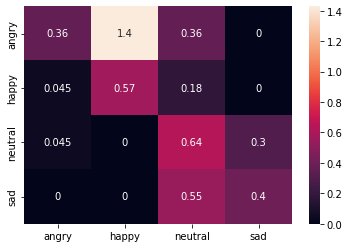

In [ ]:
#ensembled.load_weights("SAVEE//models/ensembled_loss.h5")
#test set

print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

## Testing on Crema D (manipulated)

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 5
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      y, sr = librosa.load(row['path'], mono=True, duration = 4,sr = 16000)      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "CREMA//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "CREMA//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "CREMA//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (3430, 80000, 1) (3430, 4)
Test Data (735, 80000, 1) (735, 4)
Val Data (735, 80000, 1) (735, 4)


In [ ]:
csvpath = 'CREMA/hand_engineered_features_CREMA_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'CREMA/hand_engineered_features_CREMA_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'CREMA/hand_engineered_features_CREMA_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(3430, 26) (3430, 1)
(735, 26) (735, 1)
(735, 26) (735, 1)


In [ ]:
ensembled.load_weights("SAVEE//models/ensembled_loss.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))

ensembled.load_weights("SAVEE//models/ensembled_acc.h5")
ensembled.evaluate([X_test,X_test_features],Y_test)

23/23 [==============================] - 5s 218ms/step - loss: 1.6927 - accuracy: 0.3497
[1.6926990747451782, 0.34965986013412476]
23/23 [==============================] - 4s 193ms/step - loss: 2.2088 - accuracy: 0.4000


[2.2088067531585693, 0.4000000059604645]

23/23 [==============================] - 4s 190ms/step - loss: 2.2088 - accuracy: 0.4000
[2.2088067531585693, 0.4000000059604645]
F1 SCORE: 0.39767767307841717
Kappa: 0.20559235921680508
Accuracy: 0.4
Jaccard Score: 0.25556721360966217
Precision: 0.4368971283873564
Recall: 0.4094985759666995


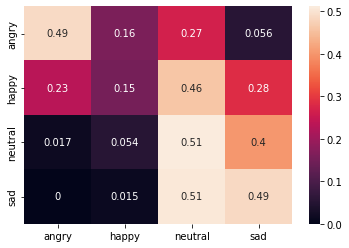

In [ ]:
#ensembled.load_weights("SAVEE//models/ensembled_loss.h5")
#test set

print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

## Testing on Tess (manipulated)

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 5
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = 4,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "TESS//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "TESS//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "TESS//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (1114, 80000, 1) (1114, 4)
Test Data (239, 80000, 1) (239, 4)
Val Data (239, 80000, 1) (239, 4)


In [ ]:
csvpath = 'TESS/hand_engineered_features_TESS_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'TESS/hand_engineered_features_TESS_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'TESS/hand_engineered_features_TESS_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)

print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(1114, 26) (1114, 1)
(239, 26) (239, 1)
(239, 26) (239, 1)


In [ ]:
ensembled.load_weights("SAVEE//models/ensembled_loss.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))

ensembled.load_weights("SAVEE//models/ensembled_acc.h5")
ensembled.evaluate([X_test,X_test_features],Y_test)

8/8 [==============================] - 2s 223ms/step - loss: 1.1918 - accuracy: 0.4686
[1.1918351650238037, 0.4686192572116852]
8/8 [==============================] - 1s 178ms/step - loss: 2.0840 - accuracy: 0.4519


[2.0839500427246094, 0.45188283920288086]

8/8 [==============================] - 2s 193ms/step - loss: 1.1918 - accuracy: 0.4686
[1.1918351650238037, 0.4686192572116852]
F1 SCORE: 0.4441321478988493
Kappa: 0.2930146973190787
Accuracy: 0.4686192468619247
Jaccard Score: 0.29060679733016626
Precision: 0.49771516680684047
Recall: 0.46973753688657127


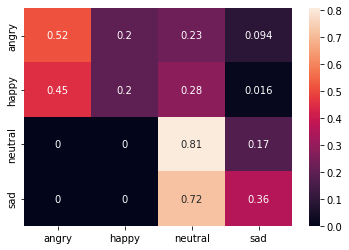

In [ ]:
ensembled.load_weights("SAVEE//models/ensembled_loss.h5")
#test set

print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

# Feb 2022

## Hamming window

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 5
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "SAVEE//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "SAVEE//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "SAVEE//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (207, 80000, 1) (207, 4)
Test Data (45, 80000, 1) (45, 4)
Val Data (44, 80000, 1) (44, 4)


In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def extract_features(csvpath,path):
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    file = open(csvpath, 'w', newline='')
    with file:
      writer = csv.writer(file)
      writer.writerow(header)
    rslt_df = pd.read_csv(path,usecols=['labels','path'])
    for index, row in rslt_df.iterrows(): 
        filename = row['path']
        y, sr = librosa.load(row['path'], mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr,window="hamming")
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr,window="hamming")
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr,window="hamming")
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr,window="hamming")
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr,window="hamming")
        to_append = f' {filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
                    to_append += f' {np.mean(e)}'
        onehot_label = label_to_onehot(row['labels'])
        to_append += f' {np.argmax(onehot_label)}'
        file = open(csvpath, 'a', newline='')
        with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split())

train_csv = "SAVEE//train.csv"
test_csv = "SAVEE//test.csv"
val_csv = "SAVEE//val.csv"
csvpath = 'SAVEE//hamming_hand_engineered_features_SAVEE_train.csv'
extract_features(csvpath,train_csv)
csvpath = 'SAVEE//hamming_hand_engineered_features_SAVEE_test.csv'
extract_features(csvpath,test_csv)
csvpath = 'SAVEE//hamming_hand_engineered_features_SAVEE_val.csv'
extract_features(csvpath,val_csv)

In [ ]:
csvpath = 'SAVEE/hamming_hand_engineered_features_SAVEE_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'SAVEE/hamming_hand_engineered_features_SAVEE_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'SAVEE/hamming_hand_engineered_features_SAVEE_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(207, 26) (207, 1)
(45, 26) (45, 1)
(44, 26) (44, 1)


In [ ]:
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)

  #out = Conv1D(4,1,activation='softmax')(out)
  #out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (26))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  #out2 = Dense(4)(layer2)
  #out2 = Reshape((4,1))(out2)

  output_layer = Average()([out,layer3])
  output_layer = Flatten()(output_layer)
  output_layer = Dense(4,activation='softmax')(output_layer)
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled = Wavenet()
ensembled.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80000, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 80000, 8)     48          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 80000, 8)     0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 80000, 8)     328         ['leaky_re_lu[0][0]']            
                                                                                              

In [ ]:
ensembled.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('SAVEE//models//ensembled_hamming_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('SAVEE//models//ensembled_hamming_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ensembled.fit([X_train,X_train_features],Y_train, batch_size=16,validation_data=([X_val,X_val_features], Y_val),epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 1.3155 - accuracy: 0.3575
Epoch 00001: val_loss improved from inf to 1.21490, saving model to SAVEE//models/ensembled_hamming_loss.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)



Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to SAVEE//models/ensembled_hamming_acc.h5
13/13 [==============================] - 18s 476ms/step - loss: 1.3155 - accuracy: 0.3575 - val_loss: 1.2149 - val_accuracy: 0.5000
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 1.0630 - accuracy: 0.6232
Epoch 00002: val_loss improved from 1.21490 to 1.09167, saving model to SAVEE//models/ensembled_hamming_loss.h5

Epoch 00002: val_accuracy did not improve from 0.50000
13/13 [==============================] - 4s 291ms/step - loss: 1.0630 - accuracy: 0.6232 - val_loss: 1.0917 - val_accuracy: 0.4773
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.8854 - accuracy: 0.6135
Epoch 00003: val_loss improved from 1.09167 to 1.06407, saving model to SAVEE//models/ensembled_hamming_loss.h5

Epoch 00003: val_accuracy did not improve from 0.50000
13/13 [==============================] - 4s 294ms/step - loss: 0.8854 - accuracy: 0.6135 - val_loss:

In [ ]:
ensembled.load_weights("SAVEE//models/ensembled_hamming_loss.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))

ensembled.load_weights("SAVEE//models/ensembled_hamming_acc.h5")
ensembled.evaluate([X_test,X_test_features],Y_test)

2/2 [==============================] - 1s 355ms/step - loss: 0.5110 - accuracy: 0.7111
[0.511020302772522, 0.7111111283302307]
2/2 [==============================] - 0s 93ms/step - loss: 0.5110 - accuracy: 0.7111


[0.511020302772522, 0.7111111283302307]

2/2 [==============================] - 0s 112ms/step - loss: 0.5110 - accuracy: 0.7111
[0.511020302772522, 0.7111111283302307]
F1 SCORE: 0.67423273657289
Kappa: 0.6039268788083954
Accuracy: 0.7111111111111111
Jaccard Score: 0.5264403907496013
Precision: 0.6856570512820513
Recall: 0.6976190476190477


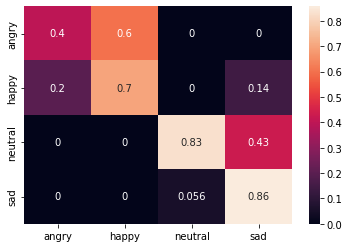

In [ ]:
#test set

print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())